# Training Progressive Growing GAN

Today we will show some basic commands to use Progressive GAN.

## 0 Prepare libraries

In [1]:
%tensorflow_version 1.x

!pip install -U -q PyDrive
!git clone https://github.com/tkarras/progressive_growing_of_gans.git
!pip install numpy==1.16
!pip install tqdm
%cd progressive_growing_of_gans

TensorFlow 1.x selected.
Cloning into 'progressive_growing_of_gans'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 350.61 KiB | 3.44 MiB/s, done.
Resolving deltas: 100% (79/79), done.
     |████████████████████████████████| 17.3MB 1.3MB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: umap-learn 0.4.3 has requirement numpy>=1.17, but you'll have numpy 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


/content/progressive_growing_of_gans


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
!nvidia-smi

Fri May 29 11:44:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '188K19ucknC6wg1R6jbuPEhTq9zoufOx4' # karras2018iclr-celebahq-1024x1024.pkl 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('karras2018iclr-celebahq-1024x1024.pkl')

In [6]:
!ls

config.py			       misc.py
dataset.py			       networks.py
dataset_tool.py			       README.md
karras2018iclr-celebahq-1024x1024.pkl  representative_image_512x256.png
legacy.py			       requirements-pip.txt
LICENSE.txt			       tfutil.py
loss.py				       train.py
metrics				       util_scripts.py


## 1 Dataset creation / download

We will first have to re-cook the input image data into their own dataset file representation.

In [0]:
!mkdir datasets

In [8]:
!ls

config.py			       misc.py
dataset.py			       networks.py
datasets			       README.md
dataset_tool.py			       representative_image_512x256.png
karras2018iclr-celebahq-1024x1024.pkl  requirements-pip.txt
legacy.py			       tfutil.py
LICENSE.txt			       train.py
loss.py				       util_scripts.py
metrics


In [0]:
!python dataset_tool.py -h

In [10]:
# Custom data?

#   tfrecord_dir       New dataset directory to be created
#   image_dir          Directory containing the images
!python dataset_tool.py create_from_images -h
#!python dataset_tool.py create_from_images datasets/CustomDataset CustomDataSource

usage: dataset_tool.py create_from_images [-h] [--shuffle SHUFFLE]
                                          tfrecord_dir image_dir

Create dataset from a directory full of images.

positional arguments:
  tfrecord_dir       New dataset directory to be created
  image_dir          Directory containing the images

optional arguments:
  -h, --help         show this help message and exit
  --shuffle SHUFFLE  Randomize image order (default: 1)

Example: dataset_tool.py create_from_images datasets/mydataset myimagedir


In [0]:
# Option A: Custom images - your own dataset:
# [!!!] We will need to pre-process our dataset so that:
# - it has square format of images
# - all the images in it are the same
# >>> Please refer to the other notebook for instructions!

# DEMO: (download two prepared images and pretend it's a dataset!)
!mkdir demo_images
%cd demo_images
!wget https://www.office.xerox.com/business-resources/1024x1024_wallpaper_tropical5.jpg
!wget https://www.office.xerox.com/business-resources/1024x1024_wallpaper_tropical1.jpg
%cd ..
!ls demo_images -luah

In [12]:
# https://drive.google.com/file/d/1r89aTKf0nWGQS8osb8cAQX24oemOooui/view?usp=sharing
file_id = '1r89aTKf0nWGQS8osb8cAQX24oemOooui'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dataset.zip')
!ls

config.py			       metrics
dataset.py			       misc.py
datasets			       networks.py
dataset_tool.py			       __pycache__
dataset.zip			       README.md
demo_images			       representative_image_512x256.png
karras2018iclr-celebahq-1024x1024.pkl  requirements-pip.txt
legacy.py			       tfutil.py
LICENSE.txt			       train.py
loss.py				       util_scripts.py


In [0]:
!unzip dataset.zip

In [0]:
!ls frames_res2

In [16]:
!python dataset_tool.py create_from_images datasets/DemoTimelapseDataset frames_res2

Loading images from "frames_res2"
Creating dataset "datasets/DemoTimelapseDataset"



Added 601 images.


In [19]:
!ls datasets/DemoTimelapseDataset/ -luah

total 2.4G
drwxr-xr-x 2 root root 4.0K May 29 11:52 .
drwxr-xr-x 3 root root 4.0K May 29 11:52 ..
-rw-r--r-- 1 root root  58K May 29 11:50 DemoTimelapseDataset-r02.tfrecords
-rw-r--r-- 1 root root 145K May 29 11:50 DemoTimelapseDataset-r03.tfrecords
-rw-r--r-- 1 root root 484K May 29 11:50 DemoTimelapseDataset-r04.tfrecords
-rw-r--r-- 1 root root 1.8M May 29 11:50 DemoTimelapseDataset-r05.tfrecords
-rw-r--r-- 1 root root 7.1M May 29 11:50 DemoTimelapseDataset-r06.tfrecords
-rw-r--r-- 1 root root  29M May 29 11:50 DemoTimelapseDataset-r07.tfrecords
-rw-r--r-- 1 root root 113M May 29 11:50 DemoTimelapseDataset-r08.tfrecords
-rw-r--r-- 1 root root 451M May 29 11:50 DemoTimelapseDataset-r09.tfrecords
-rw-r--r-- 1 root root 1.8G May 29 11:50 DemoTimelapseDataset-r10.tfrecords


In [0]:
#!python dataset_tool.py display datasets/DemoTimelapseDataset

In [0]:
# Option B: MNIST

# Download MNIST as files!
!mkdir mnist_download
%cd mnist_download

!wget https://gist.githubusercontent.com/goldsborough/6dd52a5e01ed73a642c1e772084bcd03/raw/690b3760c735c7b5f6f95e29ea0f80bf0896f81d/download_mnist.py

!python download_mnist.py
%cd ..

In [24]:
#!python dataset_tool.py create_mnist -h
!python dataset_tool.py create_mnist datasets/mnist mnist_download

Loading MNIST from "mnist_download"
Creating dataset "datasets/mnist"



Added 60000 images.


In [26]:
!ls datasets/mnist -luah

total 93M
drwxr-xr-x 2 root root 4.0K May 29 11:56 .
drwxr-xr-x 4 root root 4.0K May 29 11:56 ..
-rw-r--r-- 1 root root 3.8M May 29 11:55 mnist-r02.tfrecords
-rw-r--r-- 1 root root 6.6M May 29 11:55 mnist-r03.tfrecords
-rw-r--r-- 1 root root  18M May 29 11:55 mnist-r04.tfrecords
-rw-r--r-- 1 root root  62M May 29 11:55 mnist-r05.tfrecords
-rw-r--r-- 1 root root 2.3M May 29 11:56 mnist-rxx.labels


In [27]:
# Option C: CIFAR-10

# Download CIFAR-10 as files!
!mkdir cifar10_download
%cd cifar10_download
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz
%cd ..

/content/progressive_growing_of_gans/cifar10_download
--2020-05-29 11:57:31--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  57.6MB/s    in 2.8s    

2020-05-29 11:57:34 (57.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

/content/progressive_growing_of_gans


In [29]:
#!python dataset_tool.py create_cifar10 -h
# comment lines in dataset_tool.py
"""
    #assert images.shape == (50000, 3, 32, 32) and images.dtype == np.uint8
    #assert labels.shape == (50000,) and labels.dtype == np.int32
    #assert np.min(images) == 0 and np.max(images) == 255
    #assert np.min(labels) == 0 and np.max(labels) == 9
"""
!python dataset_tool.py create_cifar10 datasets/cifar10 cifar10_download/cifar-10-batches-py

Loading CIFAR-10 from "cifar10_download/cifar-10-batches-py"
Creating dataset "datasets/cifar10"



Added 50000 images.


In [0]:
# Option D: Dataset on Kaggle

# Check instructions at https://github.com/Kaggle/kaggle-api
!pip install kaggle
# etc

In [31]:
!ls datasets

cifar10  DemoTimelapseDataset  mnist


## 2 Training

And finally let's train!

In [0]:
!cp config.py config.py.bak

In [34]:
# We have to start by editing the config.py file
# Comment the basic "desc += '-celebahq';" line
!cat config.py | grep celebahq
# And un-comment the mnist line
!cat config.py | grep DemoTimelapseDataset

#desc += '-celebahq';            dataset = EasyDict(tfrecord_dir='celebahq'); train.mirror_augment = True
desc += '-timelapse';            dataset = EasyDict(tfrecord_dir='DemoTimelapseDataset');


In [0]:
# too loud?
!TCMALLOC_LARGE_ALLOC_REPORT_THRESHOLD=1200000000

In [36]:
!python train.py

Initializing TensorFlow...




2020-05-29 12:14:13.199075: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Running train.train_progressive_gan()...
Streaming data using dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 1024, 1024]
Dynamic range = [0, 255]
Label size    = 0
Con

In [0]:
!ls results

000-pgan-mnist-preset-v2-1gpu-fp32
001-pgan-mnist-preset-v2-1gpu-fp32
002-pgan-mnist-preset-v2-1gpu-preset-v3-1gpu-fp32
ls: cannot access 'results/002-pgan-mnist-preset-v2-1gpu-fp32': No such file or directory


In [0]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder = "results/000-pgan-mnist-preset-v2-1gpu-fp32/*"

images = []
names = []
files = glob.glob(folder)
files.sort()
image_filetypes = [".png"]

for img_path in files:
    allow = False
    for t in image_filetypes:
        if t == img_path[-4:]:
            allow = True
    if allow:
        names.append(img_path.split("/")[-1])
        images.append(mpimg.imread(img_path))

for i, image in enumerate(images):
    print(names[i], "=", image.shape)

plt.figure(figsize=(10,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    
    plt.imshow(image, cmap='gray')

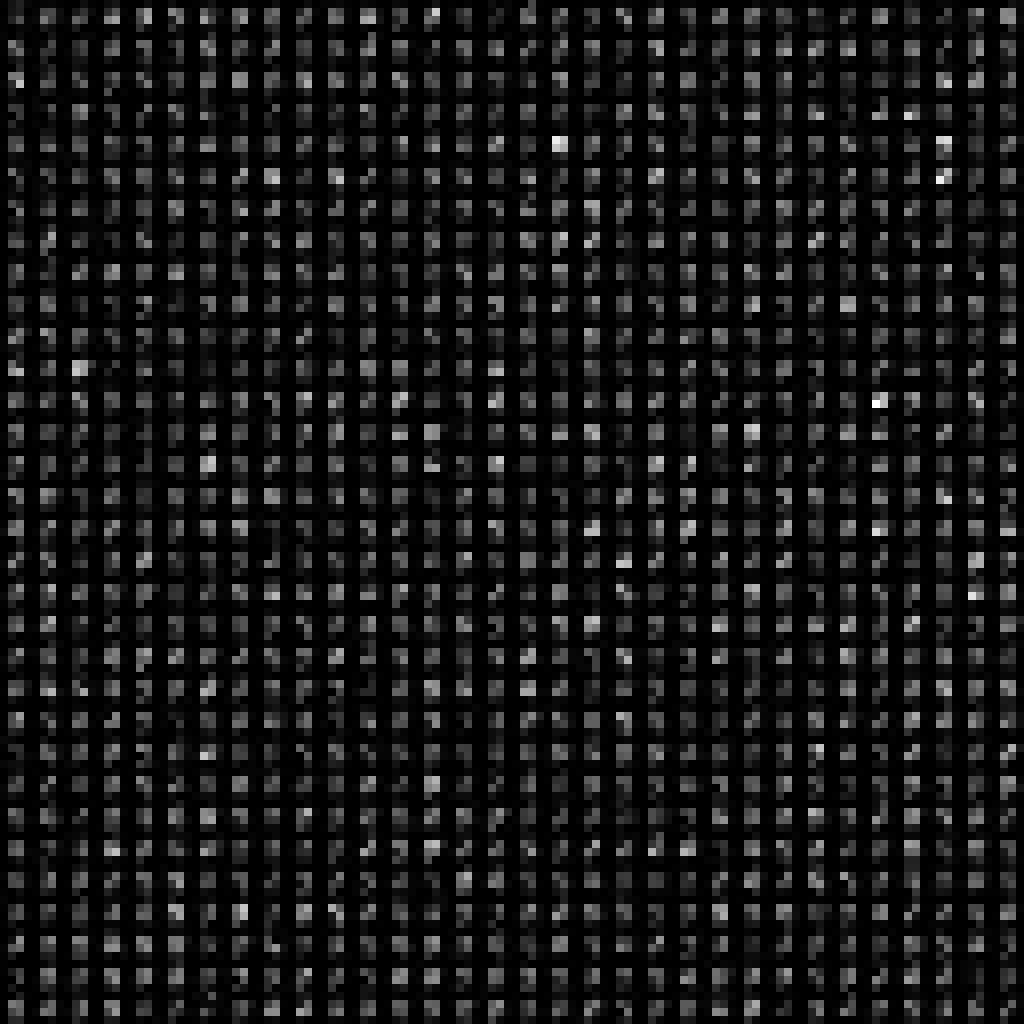

In [0]:
from IPython.display import Image
Image("results/000-pgan-mnist-preset-v2-1gpu-fp32/fakes000480.png")#, width=100, height=100)

## Bonus: resuming training of Progressive GAN:

In [0]:
# in config.py add these lines after your custom desc:
# desc += '-timelapse';            dataset = EasyDict(tfrecord_dir='DemoTimelapseDataset'); 

train.resume_run_id = 0   # opens the 000 folder - for example: 000-pgan-timelapse-preset-v2-1gpu-fp32
train.resume_snapshot = "network-snapshot-009500.pkl" # this has to be the correct network path
train.resume_kimg = 9500 # this has to correspond to the same number of already seen images as is in the name of the network